### Imports

In [0]:
import pymeanshift as pms
import numpy as np
from skimage import io, color, filters, measure
from scipy.signal import convolve2d
from sklearn.cluster import KMeans
from scipy.stats import norm
import scipy.ndimage
import matplotlib.pyplot as plt
import utilitarian

### Utility Functions

In [0]:
#################################
## Mean colour space functions ##
#################################

def rgb2hsi(im):
    '''
    RGB to HSI
    '''
    
    randno = 123111821319
    
    im = im.astype(float)
    r = im[:,:,0]
    g = im[:,:,1]
    b = im[:,:,2]
    
    I = (r+g+b)/3
    V_a = - np.sqrt(1/6.0)*r - np.sqrt(1/6.0)*g + np.sqrt(2/3.0)*b
    V_b = np.sqrt(1/6.0)*r - np.sqrt(2/3.0)*g
    S = np.sqrt(V_a**2 + V_b**2)
    H = np.reciprocal(np.tan(V_b/V_a))
    
    I = (I - I.min()) / (I.max() - I.min())
    H[np.isinf(H)] = -randno
    H[np.isnan(H)] = -randno
    H[H==-randno] = H.max()
    H = (H - H.min()) / (H.max() - H.min())
    
    return np.dstack((H,S,I))

def Hsi_fv(im, sg, nr):
    
    '''
    Returns mean Hsi for each segment
    '''
    
    hsi = rgb2hsi(im)
    ind = [None] * nr
    
    for i in range(nr):
        ind[i] = (sg == (i+1))

    desc = np.zeros((nr, 3))
    
    for i in range(3):
        feature = hsi[:,:,i]
        for j in range(nr):
            ft = feature[ind[j]]
            desc[j,i] = ft.sum() / ind[j].sum()
            
    return desc

def Hsv_fv(im, sg, nr):
    
    '''
    Returns mean HSV foe each segment.
    '''
    
    im = color.rgb2hsv(im)
    ind = [None] * nr
    
    for i in range(nr):
        ind[i] = (sg == (i+1))
    
    desc = np.zeros((nr, 3))
    
    for i in range(3):
        feature = im[:,:,i]
        for j in range(nr):
            ft = feature[ind[j]]
            desc[j,i] = ft.sum() / ind[j].sum()
            
    return desc

def Ycbcr_fv(im, sg, nr):
    
    '''
    Returns mean ycbcr for each segment
    '''
    
    im = color.rgb2ycbcr(im)
    ind = [None] * nr
    
    for i in range(nr):
        ind[i] = (sg == (i+1))
    
    desc = np.zeros((nr, 3))
    
    for i in range(3):
        feature = im[:,:,i]
        for j in range(nr):
            ft = feature[ind[j]]
            desc[j,i] = ft.sum() / ind[j].sum()
            
    return desc

#################################
##### Texton Feature Vector #####
#################################

def padCorners(im, r):
    
    impad = np.zeros((im.shape[0]+2*r,im.shape[1]+2*r))
    impad[r:-r,r:-r] = im
    impad[:r,r:-r] = np.flipud(im[:r,:]); 
    impad[-r:,r:-r] = np.flipud(im[-r:,:]);
    impad[r:-r,:r] = np.fliplr(im[:,0:r]);
    impad[r:-r,-r:] = np.fliplr(im[:,-r:]);
    impad[:r,:r] = np.flipud(np.fliplr(im[:r,:r]));
    impad[:r,-r:] = np.flipud(np.fliplr(im[:r,-r:]));
    impad[-r:,:r] = np.flipud(np.fliplr(im[-r:,0:r]));
    impad[-r:,-r:] = np.flipud(np.fliplr(im[-r:,-r:]));
    return impad

def conv2(x, y, mode='same'):
    '''do convolution of x with y'''
    return np.rot90(convolve2d(np.rot90(x, 2), np.rot90(y, 2), mode=mode), 2)

def filterBank(im):
    '''Run the filter bank on im'''
    fb = np.load('fb.npy') # filter bank stored
    impad = padCorners(im, 9)
    
    dct = dict()
    for i in range(fb.shape[0]):
        for j in range(fb.shape[1]):
            dct[i+j*12] = conv2(impad, fb[i,j])
            dct[i+j*12] = dct[i+j*12][r:-r,r:-r]
    return dct

def distComp(x,y):
    '''change later, inline'''
    z = x.T.dot(y)
    x2 = np.sum(x**2,axis=0)
    y2 = np.sum(y**2,axis=0)
    for i in range(y.shape[1]):
        z[:,i] = x2.T + y2[i] - 2*z[:,i]
    return z
            
def closestTextons(fim):
    '''closest texton for each '''
    textons = np.load('textons.npy')
    dat = np.zeros((len(fim), (fim[0].shape[0] * fim[0].shape[1])),dtype=float)
    for i in range(len(fim)):
        dat[i,:] = fim[i].ravel()
    d2 = distComp(dat, textons)
    mapo = np.argmin(d2,axis=1)
    w,h = fim[0].shape
    mapo = np.reshape(mapo, (w,h))
    return mapo

def texture_fv(rgb_im, sg, nr):
    '''
    Texture feature vector
    '''
    
    rgb_im = rgb_im.astype(float)/256.0
    gray_im = (rgb_im[:,:,0] + rgb_im[:,:,2]) / (rgb_im[:,:,1] + 1e-2)
    gray_im = gray_im / gray_im.max();
    
    fim = filterbank(gray_im)
    im = closestTextons(fim)
    
    binNum = 128
    desc = np.zeros((nr, binNum))
    
    ind = [None] * nr
    
    for i in range(nr):
        ind[i] = (sg == (i+1))
    
    for i in range(binNum):
        I = (im == (i+1))
        for j in range(nr):
            desc[j,i] = I[ind[j]].sum()
        
    tmp = np.sum(desc, axis=1)[:,np.newaxis]
    desc = desc / np.tile(tmp, (1, desc.shape[1]))
    return desc

#################################
#### Gradient Feature Vector ####
#################################

def fspecial_gaussian(shape=(4,4),sigma=2):
    """
    2D gaussian mask
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

def imgradient(gray_im):
    '''
    get image gradient
    '''
    gray_im = np.pad(gray_im,((1,1),(1,1)),'edge')
    sobelx = filters.sobel_h(gray_im)
    sobely = filters.sobel_v(gray_im)
    magnitude = 4*np.sqrt(sobelx**2.0 + sobely**2.0)[1:-1,1:-1]
    return magnitude

def gradient_fv(rgb_im, sg, nr):
    G = fspecial_gaussian()
    
    Ix = scipy.ndimage.correlate(rgb_im[:,:,0], G, mode='constant')
    
    Ig = np.zeros((Ix.shape[0],Ix.shape[1],3),dtype=float)
    for i in range(3):
        Ig[:,:,i] = scipy.ndimage.correlate(rgb_im[:,:,i], G, mode='constant')
    
    Gmag = imgradient(color.rgb2gray(Ig))
    
    binNum = 20
    Gmag = np.int32(Gmag / (Gmag.max() / binNum))
    
    desc = np.zeros((nr, binNum))
    
    ind = [None] * nr
    
    for i in range(nr):
        ind[i] = (sg == (i+1))
    
    for i in range(binNum):
        I = (Gmag == (i+1))
        for j in range(nr):
            desc[j,i] = I[ind[j]].sum()
        
    tmp = np.sum(desc, axis=1)[:,np.newaxis]
    desc = desc / np.tile(tmp, (1, desc.shape[1]))
    return desc

################################
#### Segment Centroid, Area ####
################################

def seg_fv(rgb_im, sg, nr):
    stats = measure.regionprops(sg)
    desc = dict()
    return [r.centroid for r in stats]

### Read image and perform mean shift segmentation

56


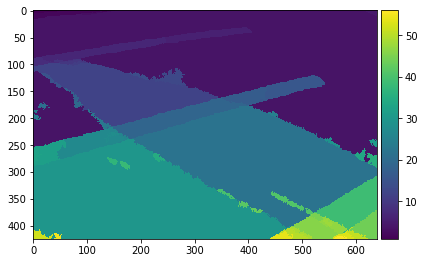

In [0]:
im = io.imread("image.jpg")[:,:,:3]

io.imshow(im)
plt.show()

(segmented_image, seg, segnum) = pms.segment(im, spatial_radius=4, range_radius=7.5, min_density=100) #9,15 : 4,7.5
seg += 1

io.imshow(seg)
#plt.savefig('output/buto2.png', dpi=400)
plt.show()

### Get the feature vectors

In [0]:
hsi = Hsi_fv(im, seg, segnum);
hsv = Hsv_fv(im, seg, segnum);
ycbcr = Ycbcr_fv(im, seg, segnum);

texthist = texture_fv(im, seg, segnum);
grad = gradient_fv(im, seg, segnum);
centroids = seg_fv(im, seg, segnum);

# Scale to 0-1 ycbcr and hsv
ycbcr[:,0] = ycbcr[:,0] / ycbcr[:,0].max();
hsv[:,0] = hsv[:,0] / hsv[:,0].max();

/home/shyamgopal/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/home/shyamgopal/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in tan
  


3.4220532319391634
[[0.60045662 0.60020557 0.5949641  ... 0.57617122 0.54338843 0.54603379]
 [0.57569222 0.56847215 0.56567516 ... 0.57656935 0.57675439 0.55742569]
 [0.55030932 0.54377267 0.54015906 ... 0.59021544 0.59021544 0.59021544]
 ...
 [0.5122322  0.56355373 0.56910847 ... 0.57595666 0.55086774 0.52678405]
 [0.53077968 0.55632476 0.55757545 ... 0.57741504 0.54835889 0.51631073]
 [0.53686018 0.56554635 0.55461985 ... 0.57726076 0.55337426 0.51952661]]


### Find nearest neighbour of each segment

[ 8.  9. 13. 11. 30.  6.  5. 20.  9. 23. 27.  3. 18. 25. 17. 16. 15. 19.
 12. 22. 31.  3. 19. 31. 16. 13. 27. 29. 30. 27. 35. 20. 31. 35. 29. 33.
 37. 31. 33. 42. 42. 42. 40. 38. 46. 47. 44. 52. 52. 53. 52. 54. 47. 49.
 51. 40.]


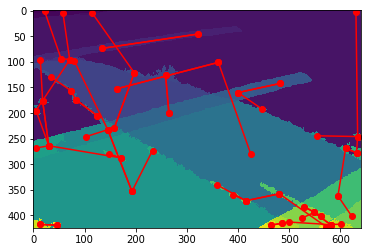

In [0]:
### Get distances
between = np.zeros((segnum, segnum), dtype=float)
for i in range(segnum):
    for j in range(segnum):
        dist = np.array([
            [centroids[i][0], centroids[i][1]],
            [centroids[j][0], centroids[j][1]]
        ])
        dist = np.sqrt((dist[0,0] - dist[1,0])**2 + (dist[0,1] - dist[1,1])**2) / max(im.shape[0],im.shape[1])
        between[i,j] = (np.abs(grad[i,:]-grad[j,:])).sum() + dist + (np.abs(texthist[i,:] - texthist[i,:])).sum()
        if i == j:
            between[i,j] = 100; 

# Get nearest and calculate total luma contrast
near = np.zeros(segnum)
hh = np.zeros(segnum)
for i in range(segnum):
    near[i] = np.argmin(between[i,:])
    j = int(near[i])
    max_ycbcr = max(ycbcr[i,0], ycbcr[j,0])
    min_ycbcr = min(ycbcr[i,0], ycbcr[j,0])
    hh[i] = min_ycbcr / max_ycbcr
    
#Plotting
plt.imshow(seg)
for i in range(segnum):
    j = int(near[i])
    plt.plot([centroids[i][1], centroids[j][1]], [centroids[i][0], centroids[j][0]], 'ro-', zorder=1)
#plt.savefig('output/buto3.png')
plt.show()

### Cluster into two using $\frac{H}{I}$

In [0]:
### KMEANS to see if it is in shadow or not
x = np.reshape(hsi[:,0]/hsi[:,2], (hsi.shape[0]))
kmeans = KMeans(n_clusters=2).fit(x[:,np.newaxis])
idx = kmeans.labels_ + 1
center = kmeans.cluster_centers_

c_std = np.zeros((2))

temp = (idx == 1)
c_std[0] = x[temp].std();
temp = (idx == 2)
c_std[1] = x[temp].std();
if center[0] > center[1]:
    center = np.sort(center)
    c_std[0], c_std[1] = c_std[1], c_std[0]

### $\bar{Luma}_x < 0.6 \cdot \bar{Luma} \implies x \in \mathbf{Shadow} $

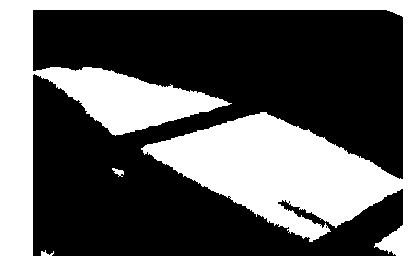

In [0]:
### SURELY IN THE SHADOW IF Y < 0.6 * avg
label = np.zeros(segnum) + 255
ycbcr_copy = np.array(ycbcr);
n_nonshadow = segnum;
avg_y = ycbcr[:,0].mean();

for i in range(ycbcr.shape[0]):
    if ycbcr[i,0] < avg_y * 0.6:
        label[i] = 0
        ycbcr_copy[i,:] = 0
        n_nonshadow = n_nonshadow - 1;

### Plotting
a = np.zeros(seg.shape)
for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        if label[seg[i,j]-1] == 0:
            a[i,j] = 1
plt.axis('off')        
io.imshow(a,cmap="gray")
#plt.savefig('./output/buto4.png')
plt.show()

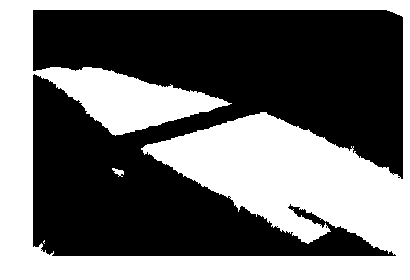

In [0]:
surely_not = np.zeros((segnum))

while True:
    update = 0
    new = 0
    max_val = 0
    for i in range(segnum):
        val = hsi[i,0] / hsi[i,2]
        t1 = norm.cdf((val - center[1])/c_std[1])
        t2 = norm.cdf(-(val - center[0])/c_std[0])
        if t2 < t1 and surely_not[i] == 0 and label[i] == 255:
            if t1 > max_val:
                new = i
                max_val = t1
                update = 1
    if update == 0 or max_val < 0.00279:
        break
    
    label[new] = 0
    j = int(near[new])
    vali = hsi[i,0] / hsi[i, 2]
    valj = hsi[j,0] / hsi[j, 2]
    if ((vali-center[1])/c_std[1]) - ((valj-center[1])/c_std[1]) > 3: 
        surely_not[j] = 1;
        label[j] = 255;
    ycbcr_copy[i,:] = 0;
    n_nonshadow = n_nonshadow - 1;
    flag = flag + 1;
    
### TEMP
a = np.zeros(seg.shape)
for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        if label[seg[i,j]-1] == 0:
            a[i,j] = 1
plt.axis('off')        
io.imshow(a,cmap="gray")
#plt.savefig('./output/buto5.png')
plt.show()    

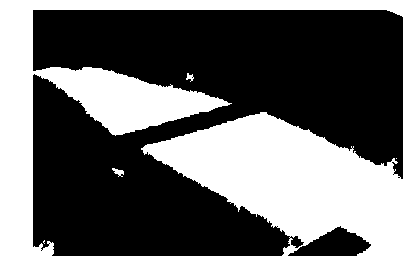

In [0]:
for i in range(segnum):
    if label[i] != 255:
        continue
    
    j = int(near[i])
    max_hsv = max(hsv[i,2], hsv[j,2])
    min_hsv = min(hsv[i,2], hsv[j,2])
    max_ycbcr = max(ycbcr[i,0], ycbcr[j,0])
    min_ycbcr = min(ycbcr[i,0], ycbcr[j,0])
    same = min_hsv / max_hsv + min_ycbcr / max_ycbcr + hh[i]
    
    if same > 2.5 and label[j] == 0:
        label[i] = 0
        
### TEMP
a = np.zeros(seg.shape)
for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        if label[seg[i,j]-1] == 0:
            a[i,j] = 1
plt.axis('off')        
io.imshow(a,cmap="gray")
#plt.savefig('./output/buto6.png')
plt.show()            

### Get final Shadow Mask

/home/shyamgopal/.local/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


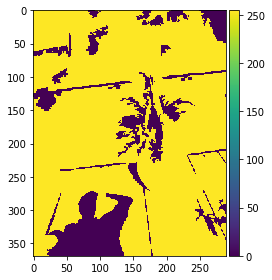

In [0]:
nseg = np.array(seg)
for i in range(seg.shape[0]):
    for j in range(seg.shape[1]):
        nseg[i,j] = label[seg[i,j]-1]
        
io.imshow(nseg)  
#plt.savefig('output/buto7.png')
plt.show()